In [1]:
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from regression_utils import *
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
# convention followed in relation to scikit documentation 
# y = countryQuantity 
# y1 = countryQuantityTrain
# Y = countryQuantityTest
# y_pred = countryQuantityPredict

# X = years 
# X1 = yearsTrain
# x_mis = yearsTest
# x = yearsPredict

# c = combinedZip

In [3]:
#reading data from csv 
df = pd.read_csv('datasets_12603_17232_Life Expectancy Data.csv')
df.fillna(df.mean(), inplace=True)

# change here 
country = 'Germany'

# extract dataframe for selected country
%store -r countryDataFrame

# Feature 1 
countryQuantity = 'life_expectancy'

#np.random.seed(5)
split = np.random.randint(1,10)/10
print('Train:Test split is: ', split, ':',round(1-split,1))
# train test split
randomRowsTrain = countryDataFrame.sample(frac=split)
randomRowsTest = countryDataFrame.loc[~countryDataFrame.index.isin(randomRowsTrain.index)]

# train test split row numbers (to keep record of train test split in order to aid plotting)
rowTrain = list(randomRowsTrain['year'].get_values())
rowTest = list(randomRowsTest['year'].get_values())

# extract data (countryQuantity) from dataframe depending on the train test split 
countryQuantityTrain = columnExtractor(randomRowsTrain, countryQuantity)
countryQuantityTest = columnExtractor(randomRowsTest, countryQuantity)

# extract data (allFeatures) from dataframe depending on the train test split 
desiredFeatures = [#'Adult Mortality', 
                   #'infant deaths', 
                   #'Alcohol',
                   #'percentage expenditure',
                   #'Hepatitis B',
                   #'Measles',
                   #'BMI',
                   #'under-five deaths',
                   #'Polio',
                   #'Total expenditure', 
                   #'Diphtheria',
                   #'HIV/AIDS',
                   #'GDP',
                   #'Population',
                   #'thinness 1-19 years',
                   #'thinness 5-9 years',
                   #'Income composition of resources',
                   #'Schooling', 
                   'year']
allFeaturesTrain = variableColumnExtractor(randomRowsTrain, desiredFeatures)
allFeaturesTest = variableColumnExtractor(randomRowsTest, desiredFeatures)

Train:Test split is:  0.7 : 0.3


lengthscale is: 
 14
[88.52148319 81.61802317 72.52705474 72.11064244 63.61848159]


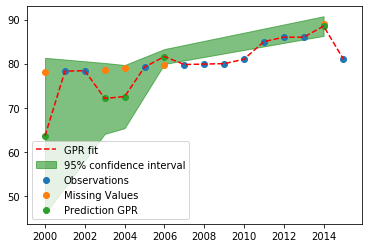

In [4]:
##Gaussian regression analysis 
lengthScale = np.random.randint(50) 
print('lengthscale is: \n',lengthScale)
kernel = C(1.0, (1e-3, 1e3)) * RBF(lengthScale, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

gp.fit(allFeaturesTrain, countryQuantityTrain)
countryQuantityPredict, sigma = gp.predict(allFeaturesTest, return_std=True)
print(countryQuantityPredict)

predictValGPR = list(zip(rowTest, list(countryQuantityPredict)))
predictValGPR.sort()

trainVal = list(zip(rowTrain, list(countryQuantityTrain)))
trainVal.sort()

valGPR = trainVal + predictValGPR
valGPR.sort(key = lambda x: x[0])

years, GPR = zip(*valGPR)

plt.plot(years, GPR,'--',color='r',label='GPR fit')
plt.fill_between(rowTest, (list(countryQuantityPredict)-2*sigma), (list(countryQuantityPredict)+2*sigma), 
                     color='green',alpha=0.5,label='95% confidence interval')
plt.scatter(rowTrain,countryQuantityTrain,label='Observations')
plt.scatter(rowTest,countryQuantityTest,label='Missing Values')
plt.scatter(rowTest,countryQuantityPredict,label='Prediction GPR') 
plt.legend()
plt.show()

[84.01825323 80.13618299 79.16566543 78.68040665 77.22463031]


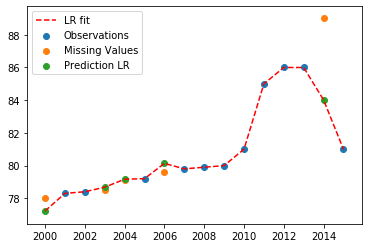

In [5]:
##Linear regression analysis 
regr = linear_model.LinearRegression()
regr.fit(allFeaturesTrain, countryQuantityTrain)

countryQuantityPredictLR = regr.predict(allFeaturesTest)
print(countryQuantityPredictLR)

predictValLR = list(zip(rowTest, list(countryQuantityPredictLR)))
predictValLR.sort()

valLR = trainVal + predictValLR
valLR.sort(key = lambda x: x[0]) 

years, LR = zip(*valLR)

plt.plot(years, LR,'--',color='r',label='LR fit')
plt.scatter(rowTrain,countryQuantityTrain,label='Observations')
plt.scatter(rowTest,countryQuantityTest,label='Missing Values')
plt.scatter(rowTest,countryQuantityPredictLR,label='Prediction LR')
plt.legend()
plt.show()

In [6]:
# error computation for GPR 
groundTruth = countryDataFrame[countryQuantity].get_values()[::-1]
print('groundTruth values \n',groundTruth)

GPR = [round(float(i),1) for i in list(GPR)]
print('GPR prediction \n',GPR)

print('------------------------------------------')

errorGPR = np.sqrt(mean_squared_error(groundTruth, GPR))

# error computation for LR 
LR = [round(float(i),1) for i in list(LR)]
print('LR prediction \n',LR) 

errorLR = np.sqrt(mean_squared_error(groundTruth, LR))
print('GPR error \n',errorGPR, '%')
print('LR error \n',errorLR, '%')

#go with rmse for outliers 
#try using normalization

groundTruth values 
 [78.  78.3 78.4 78.5 79.1 79.2 79.6 79.8 79.9 80.  81.  85.  86.  86.
 89.  81. ]
GPR prediction 
 [63.6, 78.3, 78.4, 72.1, 72.5, 79.2, 81.6, 79.8, 79.9, 80.0, 81.0, 85.0, 86.0, 86.0, 88.5, 81.0]
------------------------------------------
LR prediction 
 [77.2, 78.3, 78.4, 78.7, 79.2, 79.2, 80.1, 79.8, 79.9, 80.0, 81.0, 85.0, 86.0, 86.0, 84.0, 81.0]
GPR error 
 4.3021070419040015 %
LR error 
 1.2732831578246844 %


In [7]:
#https://yugeten.github.io/posts/2019/09/GP/
#https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html
#https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-download-auto-examples-gaussian-process-plot-gpr-co2-py
#https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/statistical_inference/supervised_learning.html